In [282]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [283]:
ba_volatility = pd.read_csv('../Inertia Trading/ba_weekly_return_volatility.csv')
ba_detailed = pd.read_csv("../Inertia Trading/ba_weekly_return_detailed.csv")

labels = ba_detailed[['Year','Week_Number', 'label']].drop_duplicates()

ba_volatility = ba_volatility.merge(
    labels, 
    on=['Year','Week_Number'], 
    how='inner'
)
ba_volatility.head()

,Year,Week_Number,mean_return,volatility,label
0,2020,0,-0.08400,0.118794,green
1,2020,1,-0.16120,1.584772,green
2,2020,2,-0.34560,1.269723,green
3,2020,3,-0.05525,2.818341,green
4,2020,4,-0.28880,1.510424,green


In [284]:
# created functions for strategy comparison to avoid code duplication
def make_weekly_prices(ba_detailed):
    return (
        ba_detailed.groupby(['Year','Week_Number'], as_index=False)
        .agg(Open_w=('Open','first'), Close_w=('Close','last'))
        .sort_values(['Year','Week_Number'])
        .reset_index(drop=True)
    )
    
def buy_and_hold(weekly_prices, initial=100.0):
    wp = weekly_prices.sort_values(['Year','Week_Number']).reset_index(drop=True)
    yearly = (
        wp.groupby('Year', as_index=False)
          .agg(Close_y=('Close_w','last'))
          .sort_values('Year')
          .reset_index(drop=True)
    )
    shares = initial / wp.iloc[0]['Open_w']
    yearly['BuyHold'] = (shares * yearly['Close_y']).round(2)
    return yearly

def trading(df, label_col='predicted_label', green_value='green', initial=100.0):
    cash = initial
    shares = 0
    results = {}
    
    for i in range(len(df)):
        this_week = df.iloc[i]
        next_week = df.iloc[i+1] if i+1 < len(df) else None 
        
        if(shares == 0 and this_week[label_col] == green_value):
            shares = cash / this_week['Open_w']
            cash = 0
            
        if shares > 0 and ((next_week is None) or next_week[label_col] != green_value):
            cash = shares * this_week['Close_w']
            shares = 0

        year_end = (i == len(df)-1) or (this_week['Year'] != next_week['Year'])
        if year_end: #store yearly earnings/losses
            wealth = shares*this_week['Close_w'] if shares > 0 else cash
            results[this_week['Year']] = round(wealth, 2)
    return df[['Year']].drop_duplicates().assign(value=df['Year'].map(results))['value']

def compare_strategies(ba_detailed, labels_df, strategy_name, label_col='predicted_label', green_value='green', initial=100.0):
    weekly_prices = make_weekly_prices(ba_detailed)
    weekly_prices = weekly_prices.merge(labels_df, on=['Year','Week_Number'], how='inner').sort_values(['Year','Week_Number']).reset_index(drop=True)
    
    portfolio = buy_and_hold(weekly_prices, initial=initial)
    trad_str = trading(weekly_prices, label_col=label_col, green_value=green_value, initial=initial)
    trad_str_df = pd.DataFrame({'Year': weekly_prices['Year'].unique(), strategy_name: trad_str})

    portfolio = portfolio.merge(trad_str_df, on='Year', how='left')
    return portfolio

In [285]:
train_df = ba_volatility[ba_volatility['Year'] < 2023]
test_df = ba_volatility[ba_volatility['Year'] >= 2023]

## Decision Tree Classifiers (Entropy vs Gini)


In [286]:
features = ['mean_return', 'volatility']
X_train = train_df[features].values
le = LabelEncoder()
Y_train = le.fit_transform(train_df['label'].values)

X_test = test_df[features].values
Y_test = le.transform(test_df['label'].values)

tree_classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=79)
tree_classifier.fit(X_train, Y_train)
predicted = tree_classifier.predict(X_test)
accuracy = np.mean(predicted == Y_test)
print(f"Testing accuracy: {accuracy}")

cm = confusion_matrix(Y_test, predicted)
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix:\n{cm}")

tpr = tp / (tp + fn)
tnr = tn / (fp + tn)
print(f"TPR: {tpr:.3f}")
print(f"TNR: {tnr:.3f}")


test_df = test_df.copy()
test_df['predicted_label_dt'] = le.inverse_transform(predicted)
# test_df.head()

dt_portfolio = compare_strategies(ba_detailed, test_df, label_col='predicted_label_dt', strategy_name="DecisionTree")
print("\nBuy-and-Hold vs Trading Strategy:")
print(dt_portfolio)

Testing accuracy: 1.0

Confusion Matrix:
[[89  0]
 [ 0 16]]
TPR: 1.000
TNR: 1.000

Buy-and-Hold vs Trading Strategy:
   Year     Close_y  BuyHold  DecisionTree
0  2023  260.660004   135.09        181.28
1  2024  176.550003    91.50        294.39


After implementing decision tree with default 'entropy' splitting criteria, we got 100% accuracy. The TPR and TNR also equals to 1. 

The trading strategy based on Decision Tree predictions resulted in higher cumulative gains (`$294`) compared to buy-and-hold strategy (`$92`).

For the “gini” splitting criterion, the model achieved identical accuracy, TPR, TNR, and financial results—suggesting that both criteria lead to the same decision boundaries for this dataset.

In [287]:
# gini
tree_classifier_gini = tree.DecisionTreeClassifier(criterion='gini', random_state=79)
tree_classifier_gini.fit(X_train, Y_train)
predicted_gini = tree_classifier_gini.predict(X_test)
accuracy_gini = np.mean(predicted_gini == Y_test)
print(f"Testing accuracy: {accuracy_gini}")

cm = confusion_matrix(Y_test, predicted_gini)
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix:\n{cm}")

tpr = tp / (tp + fn)
tnr = tn / (fp + tn)
print(f"TPR: {tpr:.3f}")
print(f"TNR: {tnr:.3f}")

test_df = test_df.copy()
test_df['predicted_label_dt_gini'] = le.inverse_transform(predicted_gini)
# print(test_df.head())

dt_portfolio = compare_strategies(ba_detailed, test_df, label_col='predicted_label_dt_gini', strategy_name="DecisionTreeGini")
print("\nBuy-and-Hold vs Trading Strategy:")
print(dt_portfolio)

Testing accuracy: 1.0

Confusion Matrix:
[[89  0]
 [ 0 16]]
TPR: 1.000
TNR: 1.000



Buy-and-Hold vs Trading Strategy:
   Year     Close_y  BuyHold  DecisionTreeGini
0  2023  260.660004   135.09            181.28
1  2024  176.550003    91.50            294.39


## Random Forest Classifiers (Entropy vs Gini)

In [288]:
from sklearn.ensemble import RandomForestClassifier

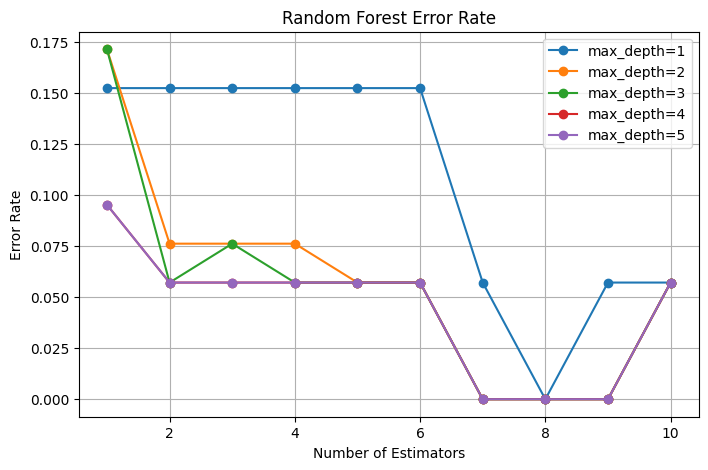

In [289]:
features = ['mean_return', 'volatility']
X_train = train_df[features].values
le = LabelEncoder()
Y_train = le.fit_transform(train_df['label'].values)

X_test = test_df[features].values
Y_test = le.transform(test_df['label'].values)


subtrees_num=np.arange(1, 11)
depths=np.arange(1, 6)
results = []
for n in subtrees_num:
    for d in depths:
        model = RandomForestClassifier(n_estimators=n, max_depth=d, criterion='entropy', random_state=79)
        model.fit(X_train, Y_train)
        predicted = model.predict(X_test)
        err_rate = np.mean(predicted != Y_test)
        results.append((n, d, err_rate))


results_df = pd.DataFrame(results, columns=['n_estimators', 'max_depth', 'error_rate'])
plt.figure(figsize=(8,5))
for d in depths:
    subset = results_df[results_df['max_depth'] == d].sort_values('n_estimators')
    plt.plot(subset['n_estimators'], subset['error_rate'], marker='o', label=f'max_depth={d}')
plt.xlabel('Number of Estimators')
plt.ylabel('Error Rate')
plt.title('Random Forest Error Rate')
plt.legend()
plt.grid()
plt.show()

The error rate plot shows that increasing the number of estimators reduces misclassification, and it applies for moderate depths (d=3-5).

In [290]:
best = results_df.sort_values(['error_rate','n_estimators','max_depth'], ascending=[True, False, True]).iloc[0]
best_N, best_d = int(best.n_estimators), int(best.max_depth)
print(f"Best params -> N={best_N}, d={best_d}, error={best.error_rate:.4f}, accuracy={1-best.error_rate:.4f}")

rf_classifier = RandomForestClassifier(n_estimators=best_N, max_depth=best_d, criterion='entropy', random_state=79)
rf_classifier.fit(X_train, Y_train)
predicted = rf_classifier.predict(X_test)
accuracy = np.mean(predicted == Y_test)
print(f"Testing accuracy: {accuracy}")

cm=confusion_matrix(Y_test, predicted)
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix:\n{cm}")

tpr = tp / (tp + fn)
tnr = tn / (fp + tn)
print(f"TPR: {tpr:.3f}")
print(f"TNR: {tnr:.3f}")

test_df = test_df.copy()
test_df['predicted_label_rf'] = le.inverse_transform(predicted)
# test_df.head()

rf_portfolio = compare_strategies(ba_detailed, test_df, label_col='predicted_label_rf', strategy_name="RandomForest")
print("\nBuy-and-Hold vs Trading Strategy:")
print(rf_portfolio)

Best params -> N=9, d=2, error=0.0000, accuracy=1.0000
Testing accuracy: 1.0

Confusion Matrix:
[[89  0]
 [ 0 16]]
TPR: 1.000
TNR: 1.000

Buy-and-Hold vs Trading Strategy:
   Year     Close_y  BuyHold  RandomForest
0  2023  260.660004   135.09        181.28
1  2024  176.550003    91.50        294.39


After performing a grid search over N(0-10), d(1-5) the optimal combination is N=9 and d=2 with 100% accuracy. Both the confusion matrix and metrics confirm perfect classification—every “green” and “red” week was correctly predicted.

The Random Forest trading strategy yields substantially higher cumulative returns (`$294`) compared to Buy-and-Hold (`$92`). The results as same as Decision Tree. 

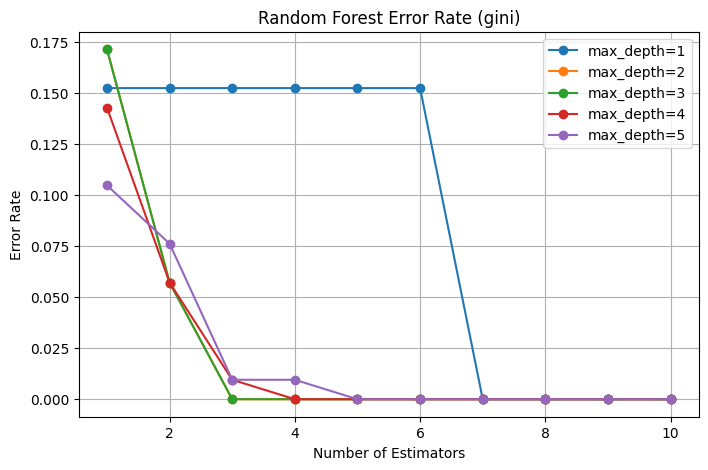

In [291]:
# gini
features = ['mean_return', 'volatility']
X_train = train_df[features].values
le = LabelEncoder()
Y_train = le.fit_transform(train_df['label'].values)

X_test = test_df[features].values
Y_test = le.transform(test_df['label'].values)


subtrees_num=np.arange(1, 11)
depths=np.arange(1, 6)
results = []
for n in subtrees_num:
    for d in depths:
        model = RandomForestClassifier(n_estimators=n, max_depth=d, criterion='gini', random_state=79)
        model.fit(X_train, Y_train)
        predicted = model.predict(X_test)
        err_rate = np.mean(predicted != Y_test)
        results.append((n, d, err_rate))


results_df = pd.DataFrame(results, columns=['n_estimators', 'max_depth', 'error_rate'])
plt.figure(figsize=(8,5))
for d in depths:
    subset = results_df[results_df['max_depth'] == d].sort_values('n_estimators')
    plt.plot(subset['n_estimators'], subset['error_rate'], marker='o', label=f'max_depth={d}')
plt.xlabel('Number of Estimators')
plt.ylabel('Error Rate')
plt.title('Random Forest Error Rate (gini)')
plt.legend()
plt.grid()
plt.show()

When using the 'gini' criterion, for small dephts (d=1-2) the error rate sharply decrease as N increase. While for d=3-5 the error reaches zero by N>=3.

In [292]:
best = results_df.sort_values(['error_rate','n_estimators','max_depth'], ascending=[True, False, True]).iloc[0]
best_N, best_d = int(best.n_estimators), int(best.max_depth)
print(f"Best params -> N={best_N}, d={best_d}, error={best.error_rate:.4f}, accuracy={1-best.error_rate:.4f}")


rf_classifier = RandomForestClassifier(n_estimators=best_N, max_depth=best_d, criterion='gini', random_state=79)
rf_classifier.fit(X_train, Y_train)
predicted = rf_classifier.predict(X_test)
accuracy = np.mean(predicted == Y_test)
print(f"Testing accuracy: {accuracy}")

cm=confusion_matrix(Y_test, predicted)
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix:\n{cm}")

tpr = tp / (tp + fn)
tnr = tn / (fp + tn)
print(f"TPR: {tpr:.3f}")
print(f"TNR: {tnr:.3f}")

test_df = test_df.copy()
test_df['predicted_label_rf_gini'] = le.inverse_transform(predicted)
# test_df.head()

rf_portfolio = compare_strategies(ba_detailed, test_df, label_col='predicted_label_rf_gini', strategy_name="RandomForest")
print("\nBuy-and-Hold vs Trading Strategy:")
print(rf_portfolio)

Best params -> N=10, d=1, error=0.0000, accuracy=1.0000
Testing accuracy: 1.0

Confusion Matrix:
[[89  0]
 [ 0 16]]
TPR: 1.000
TNR: 1.000

Buy-and-Hold vs Trading Strategy:
   Year     Close_y  BuyHold  RandomForest
0  2023  260.660004   135.09        181.28
1  2024  176.550003    91.50        294.39


The optimal values of N, d are 10 and 1 with 100% accuracy. While the number of estimators and depths are different fot gini createrion, the results are same as entropy criterion. 

This demonstrates that, for this dataset, the choice of splitting criterion (entropy vs. gini) has no practical impact on the model’s predictive ability or financial outcome.
Both models perfectly replicate the true weekly labels, leading to the same 100% accuracy and the same portfolio growth trajectory.

## Hamming Distance

In [293]:
test_df_dummified = test_df.replace({'green': 1, 'red': 0}).copy()
test_df_dummified = test_df_dummified.sort_values(['Year','Week_Number']).reset_index(drop=True)
test_df_dummified['Week_Index'] = np.arange(1, len(test_df_dummified)+1) 
test_df_dummified.head()

/var/folders/nc/5dc3_9y52yv6qhckcby4v4dc0000gn/T/ipykernel_7951/3497093624.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df_dummified = test_df.replace({'green': 1, 'red': 0}).copy()


,Year,Week_Number,mean_return,volatility,label,predicted_label_dt,predicted_label_dt_gini,predicted_label_rf,predicted_label_rf_gini,Week_Index
0,2023,1,2.84125,1.618816,1,1,1,1,1,1
1,2023,2,0.12040,1.912990,1,1,1,1,1,2
2,2023,3,-0.87075,0.492591,1,1,1,1,1,3
3,2023,4,0.42620,0.875527,1,1,1,1,1,4
4,2023,5,-0.48200,1.689419,1,1,1,1,1,5


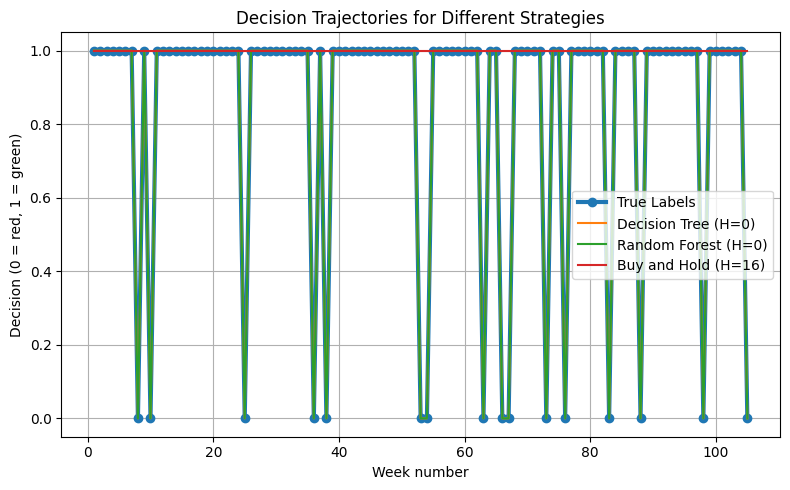

In [294]:
buy_hold = np.ones(len(test_df_dummified))
true_labels = test_df_dummified['label'].values
dt_labels = test_df_dummified['predicted_label_dt'].values
rf_labels = test_df_dummified['predicted_label_rf'].values

h_dt = np.sum(dt_labels!=true_labels)
h_rf = np.sum(rf_labels!=true_labels)
h_bh = np.sum(buy_hold!=true_labels)

plt.figure(figsize=(8,5))
plt.plot(test_df_dummified['Week_Index'], true_labels, marker='o', lw=3, label='True Labels')
plt.plot(test_df_dummified['Week_Index'], dt_labels, label=f'Decision Tree (H={h_dt})')
plt.plot(test_df_dummified['Week_Index'], rf_labels, label=f'Random Forest (H={h_rf})')
plt.plot(test_df_dummified['Week_Index'], buy_hold, label=f'Buy and Hold (H={h_bh})')

plt.xlabel('Week number')
plt.ylabel('Decision (0 = red, 1 = green)')
plt.title('Decision Trajectories for Different Strategies')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

To avoid overlap on x-axis across two years(each year with week numbers 1-52), I created new column week_index (1-104) sorted by Year, Week Number.

The trajectory plot above shows that both decision tree and random forest strategies match the True labels on every test week with 100% accuracy, while buy-and-hold differs on 16 weeks.

In [295]:
seqs = {
    'BuyHold'   : buy_hold,
    'True'      : true_labels,
    'DT'        : dt_labels,
    'RF'        : rf_labels,
}
names = list(seqs.keys())
M = np.zeros((4,4), dtype=int)
for i,a in enumerate(names):
    for j,b in enumerate(names):
        M[i,j] = int(np.sum(seqs[a] != seqs[b]))

M_df = pd.DataFrame(M, index=names, columns=names)
print(M_df)

         BuyHold  True  DT  RF
BuyHold        0    16  16  16
True          16     0   0   0
DT            16     0   0   0
RF            16     0   0   0


The 4x4 Hamming matrix is symmetric with zeros on the diagonal, values for Decision Tree and Random Forest are identical to True (all zeros), and Buy-and-Hold shows 16 for each of the other three sequences. The values also relate to confusion matrices, where we got TP=16 identifying 16 weeks labeled as 'red'.